In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import plot_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('fer2013.csv') #Reading the FER2013 dataset
data = data[data['emotion']!=1] #Kicking disgust out
new_emo_num_map = {0: 0, 2: 2, 3: 3, 4: 4, 5: 5, 6: 1} #remapping as 6 to 1
data['emotion'] = data['emotion'].map(new_emo_num_map)
# data

In [ ]:
emotion_map = {0: 'Angry', 1: 'Neutral', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise'}
emotion_counts = data['emotion'].value_counts(sort = False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

emotion_counts

In [ ]:
plt.figure()
# print('\n')
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number of Sample')
plt.xlabel('Emotional Status')

In [2]:
def CRNO(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    #pixel_sequence = df['pixels']
    #df['pixels'] = [int(pixel) for pixel in pixel_sequence.split()]
    data_X = np.array(df['pixels'].tolist(), dtype = 'float32').reshape(-1, width, height, 1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    return data_X, data_Y

In [3]:
data = pd.read_csv('fer2013.csv')

In [4]:
data_generator = ImageDataGenerator(featurewise_center = True, #False,
                                    featurewise_std_normalization = False,
                                    rotation_range = 20,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.3,
                                    horizontal_flip = True)

# es = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
# es = EarlyStopping(monitor = 'val_accuracy', patience = 30, mode = 'max', restore_best_weights = True)

In [12]:
num_classes = 7 #Disgust out
width, height = 48, 48
num_epochs = 120
batch_size = 64
num_features = 64

In [6]:
fold_number = 8

In [7]:
data['KFold'] = range(len(data))
data['KFold'] = data['KFold']%fold_number
data.drop('Usage', inplace= True, axis= 1)

In [ ]:
for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()

    #module 1
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 2
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 3
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #flatten
    model.add(Flatten())

    #dense 1
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 2
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 3
    model.add(Dense(num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

    model.summary()
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                    steps_per_epoch = len(train_X) / batch_size,
                    epochs = num_epochs,
                    verbose = 1,
                    callbacks = [es],
                    validation_data = (val_X, val_Y))
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
    scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
for kf in [1]: #range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()

    #module 1
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding = 'same', input_shape=((width, height, 1)), data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 2
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #module 3
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(8*num_features, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #flatten
    model.add(Flatten())

    #dense 1
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 2
    model.add(Dense(16*num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #dense 3
    model.add(Dense(num_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=1e-6), #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                        steps_per_epoch = len(train_X) / batch_size,
                        epochs = num_epochs,
                        verbose = 1,
                        callbacks = callbacks, #[es],
                        validation_data = (val_X, val_Y),
                        validation_steps=len(val_X) / batch_size)
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
    scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

(31401, 3) (4486, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (Non

190/490 [==========>...................] - ETA: 7s - loss: 3.6525 - accuracy: 0.2495

KeyboardInterrupt: 

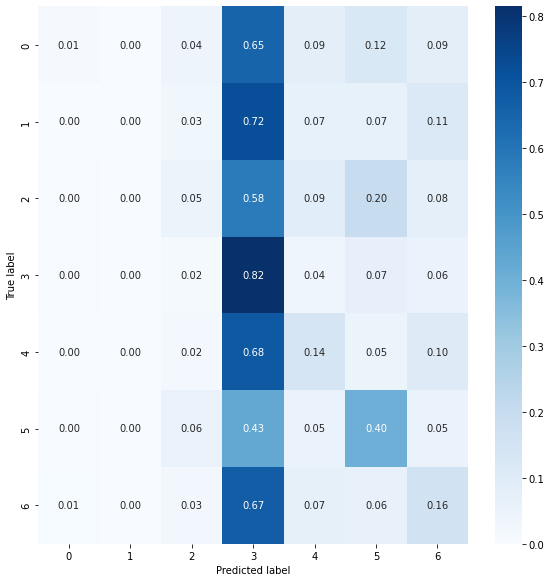

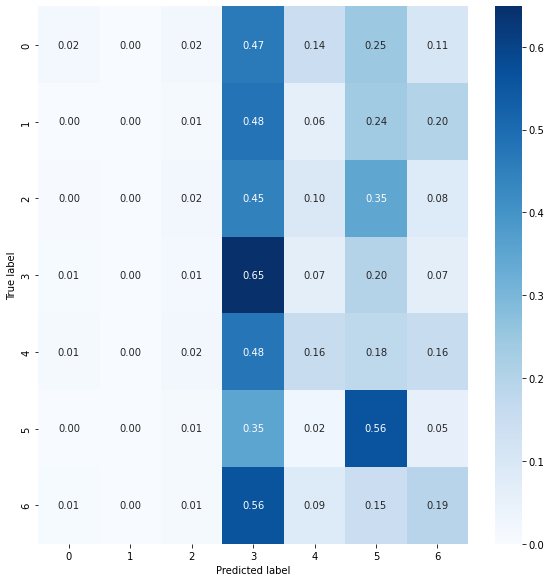

In [11]:
scorelist = []

for kf in range(fold_number):
    data_train = data[data['KFold'] != kf].copy()
    data_val = data[data['KFold'] == kf].copy()
    
    print(data_train.shape, data_val.shape)
    
    train_X, train_Y = CRNO(data_train)
    val_X, val_Y = CRNO(data_val)
    
    model = Sequential()
    
    # Conv Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =((width, height, 1)), data_format='channels_last'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    # Conv Layer 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Dense Layer 1
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=1e-6), #Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), #lr= 0.001
                  metrics=['accuracy'])

    # model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    
    
    chk_path = '10_fold_iter/ferNet_'+str(kf+1)+'.h5'
    log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

    earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    csv_logger = CSVLogger('10_fold_iter/training_'+str(kf+1)+'.log')

    callbacks = [checkpoint, reduce_lr, csv_logger]
    
    history = model.fit(data_generator.flow(train_X, train_Y, batch_size),
                        steps_per_epoch = len(train_X) / batch_size,
                        epochs = num_epochs,
                        verbose = 0,
                        callbacks = callbacks, #[es],
                        validation_data = (val_X, val_Y),
                        validation_steps=len(val_X) / batch_size)
    
    score = model.evaluate(val_X, val_Y, verbose=1)
    print(score[1])
    scorelist.append(score[1])
    
    # Creating and saving confusion matrix
    pred_Y=model.predict(val_X)
    tesst_Y=np.argmax(val_Y, axis=1)
    pred_Y=np.argmax(pred_Y,axis=1)
    cmatrix=confusion_matrix(tesst_Y, pred_Y)
    cmatrix = cmatrix.astype('float')/cmatrix.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cmatrix, annot=True, fmt= '.2f', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('10_fold_iter/Confusion_'+str(kf+1)+'_val_acc_'+str(score[1])+'_10_fold.png')

    # Saving the models
    # model.save('10_fold_iter/model_10_fold_iter_KF_'+ str(kf+1) + '.h5')



np.savetxt("10_fold_iter/test_accuracy.csv", scorelist, delimiter =",")